In [28]:
import PyTCI, matplotlib

In [29]:
example_patient = {
    "age": 80,
    "weight": 85,
    "height": 191,
    "sex": 'm',
}

bolus_dose = 200

In [30]:
from PyTCI.weights import leanbodymass
from PyTCI.models import propofol
        
model_parameters = [0.1455, 0.094332, 0.0643, 0.626, 0.0609, 0.7895, 0.6413, 0.0181, 0.2004]

class HackDay_model(propofol.Propofol):
    def __init__(self, age, weight, height, sex, params):
        
        lean_body_mass = leanbodymass.hume71(height, weight, sex)
        
        self.v1 = (params[1] * lean_body_mass) * (age **(-params[2]))
        self.v2 = params[3] * lean_body_mass * 2
        self.v3 = params[4] * weight * 5
        
        self.Q1 = (params[5] * (weight ** 0.75) ) * (age ** (-params[6]))
        self.Q2 = params[7] * (self.v2 ** 0.75)
        self.Q3 = params[8] * (self.v3 ** 0.75)
        
        self.keo = 0
        
        propofol.Propofol.from_clearances(self)
        propofol.Propofol.setup(self)   

In [31]:
pt1 = propofol.Schnider(example_patient["age"], example_patient["weight"], example_patient["height"], example_patient["sex"])
pt2 = propofol.Eleveld(example_patient["age"], example_patient["weight"], example_patient["height"], example_patient["sex"])
pt2.keo = pt2.keo

pt3 = HackDay_model(example_patient["age"], example_patient["weight"], example_patient["height"], example_patient["sex"], model_parameters)
pt3.keo = 0.2/60

NameError: name 'solve_for_custom' is not defined

In [32]:
print(pt1.keo)
print(pt2.keo)
print(pt3.keo)

0.0076
0.0023180424451902603
0.0033333333333333335


In [33]:
from IPython.display import Markdown


Markdown("""
#### Resulting pharmacokinetic values



| Model | V1 | V2 | V3 | CL |
| ----- | -- | ---| -- | -- |
| Schnider | {pt1v1} | {pt1v2} | {pt1v3} | {pt1k10} |
| Eleveld | {pt2v1} | {pt2v2} | {pt2v3} | {pt2k10} |
| HackDay | {pt3v1} | {pt3v2} | {pt3v3} | {pt3k10} |
""".format(pt1v1 = round(pt1.v1, 2), pt1v2 = round(pt1.v2, 2), pt1v3 = round(pt1.v3, 2), pt1k10 = round(pt1.k10* 60, 2),
           pt2v1 = round(pt2.v1, 2), pt2v2 = round(pt2.v2, 2), pt2v3 = round(pt2.v3), pt2k10 = round(pt2.k10* 60, 2),
           pt3v1 = round(pt3.v1, 2), pt3v2 = round(pt3.v2, 2), pt3v3 = round(pt3.v3), pt3k10 = round(pt3.k10* 60, 2)
))


#### Resulting pharmacokinetic values



| Model | V1 | V2 | V3 | CL |
| ----- | -- | ---| -- | -- |
| Schnider | 4.27 | 8.34 | 238 | 0.47 |
| Eleveld | 6.66 | 15.35 | 337 | 0.31 |
| HackDay | 4.72 | 83.01 | 26 | 0.28 |


<IPython.core.display.Javascript object>


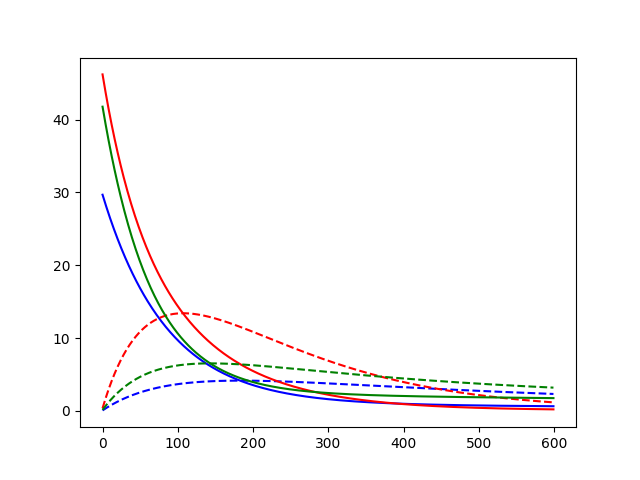

In [34]:
%matplotlib notebook

import matplotlib.pyplot as plt

marshcp = []
marshce = []
schnidercp = []
schniderce = []
sivacp = []
sivace = []

pt1.give_drug(bolus_dose)
pt2.give_drug(bolus_dose)
pt3.give_drug(bolus_dose)

for i in range(600):
    pt1.wait_time(1)
    pt2.wait_time(1)
    pt3.wait_time(1)
    
    marshcp.append(pt2.x1)
    marshce.append(pt2.xeo)
    schnidercp.append(pt1.x1)
    schniderce.append(pt1.xeo)
    sivacp.append(pt3.x1)
    sivace.append(pt3.xeo)
    
induction_graph = plt.plot(marshcp, 'b', marshce, 'b--', schnidercp, 'r', schniderce, 'r--', sivacp, 'g', sivace, 'g--' )

plt.show()

In [35]:
def zero_compartments(patient):
    patient.x1 = 0
    patient.x2 = 0
    patient.x3 = 0
    patient.xeo = 0
    
zero_compartments(pt1)
zero_compartments(pt2)
zero_compartments(pt3)

<IPython.core.display.Javascript object>


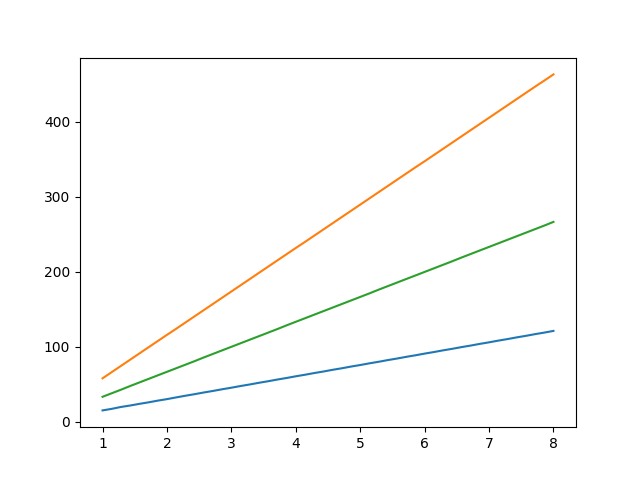

In [36]:
import numpy
marsh_bolus = []
schnider_bolus= []
siva_bolus = []

effect_target = numpy.linspace(1,8)

for i in effect_target:
    marsh_bolus.append(pt1.effect_bolus(i))
    schnider_bolus.append(pt2.effect_bolus(i))
    siva_bolus.append(pt3.effect_bolus(i))
    
fig2 = plt.figure()
plt.plot(effect_target, marsh_bolus)
plt.plot(effect_target, schnider_bolus)
plt.plot(effect_target, siva_bolus)
plt.show()